## imports

In [423]:
import collections
import glob
import json
import os
import uuid

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.legend import Legend
import pandas as pd
from scipy import ndimage

## utilities

### I/O

#### logs

In [406]:
def read_events(fname):
    success_statuses = ['KSP_CONVERGED_RTOL', 'SCIPY_SUCCESS', 'AZ_normal', 
                        'KSP_CONVERGED_ITS', 'KSP_CONVERGED_RTOL', 
                        'Pysparse_CONVERGED_RTOL', 'AMGX_SOLVE_SUCCESS']
    events = []
    state = {}
    versions = {}

    with open(fname, 'r') as f:
        begin_time = np.nan
        solve_time = np.nan
        simulation_id = np.nan
        for line in f:
            entries = line.split("|")
            # Python version uses '|', too
            entries = entries[:4] + ["|".join(entries[4:])]

            (time_stamp,
             level,
             logger,
             function,
             msg) = [s.strip() for s in entries]

            if (logger, function) == ("fipy.solvers", "<module>"):
                pass
            elif (level, logger, function) == ("DEBUG", "fipy", "<module>"):
                versions = json.loads(msg)
                # # fix name collision
                # versions["package"]["solver_suite"] = versions["package"]["solver"]
                # del versions["package"]["solver"]
            elif (level, logger, function) == ("INFO", "fipy", "<module>"):
                # obsolete log format
                versions = {"package": json.loads(msg)}
            elif (level, function) == ("DEBUG", "<module>"):
                if msg.startswith("result stored in"):
                    continue
                state = json.loads(msg)
                state["logfile"] = fname
                state["time_stamp"] = time_stamp
                state["solver_class"] = logger.split('.')[-1]
                state["solve_time"] = str(solve_time)
                if state["state"] == "START":
                    # create unique id for each simulation run
                    simulation_id = uuid.uuid4()
                    converged = False
                state["simulation_id"] = simulation_id
                state["converged"] = converged
                state.update(versions)
                events.append(state.copy())
            elif (level, function) == ("DEBUG", "_setConvergence"):
                state["state"] = "SWEEP"
                event = json.loads(msg)
                event.update(state.copy())
                event["time_stamp"] = time_stamp
                event["solver_class"] = logger.split('.')[-1]
                event["solve_time"] = str(solve_time)
                converged = event["status_name"] in success_statuses
                events.append(event)
            elif (level, function) == ("DEBUG", "_solve_"):
                if msg == "BEGIN solve":
                    begin_time = pd.to_datetime(time_stamp)
                    solve_time = np.nan
                elif msg == "END solve":
                    solve_time = pd.to_datetime(time_stamp) - begin_time
                    begin_time = np.nan

    return events

def events2df(events):
    df = pd.json_normalize(events)
    df["time_stamp"] = pd.to_datetime(df["time_stamp"])
    df["solve_time"] = pd.to_timedelta(df["solve_time"])    
    df.loc[df["preconditioner"].isna()
           | (df["preconditioner"] == "NoneType"), "preconditioner"] = "unpreconditioned"

    return df

def extract_total_times(df):
    df2 = df[df["state"].isin(["START", "END"])].copy()
    df2["time_delta"] = df2["time_stamp"].diff()
    df2["elapsed_seconds"] = df2["time_delta"] / pd.Timedelta("00:00:01")

    return df2[df2["state"] == "END"].sort_values("numberOfElements")

def extract_sweep_times(df):
    df2 = df.copy()
    df2["time_delta"] = df["time_stamp"].diff()
    df2["elapsed_seconds"] = df2["time_delta"] / pd.Timedelta("00:00:01")

    return df2[~df2["state"].isin(["START", "END"])]

#### data files

In [772]:
def read_tsv(tsv):
    x, y, v = np.loadtxt(tsv, skiprows=1, unpack=True)
    N = int(np.sqrt(len(x)))
    return [field.reshape((N,N)) for field in (x, y, v)] + [N]

def read_npz(npz):
    data = np.load(npz)
    return data["x"], data["y"], data["value"], data["value"].shape[0]

def tsv2npz(tsv):
    x, y, v, N = read_tsv(tsv)
    np.savez(os.path.splitext(tsv)[0], x=x, y=y, value=v)

In [774]:
def load_field(record, fname, key):
    """Load and intorpolate `path2` to resolution of `path1`
    
    Parameters
    ----------
    record : pd.Series
        Pandas Series with information about particular results to load.
    fname : str
        Name of `.npz` file containing x-coordinates, y-coordinates, and values
        to load from directory hierarchy determined by "logfile",
        "package.solver", "solver_class", "preconditioner", "numberOfElements"
        fields in `record`.
    key : str
        Designation of the field of interest within `fname`.

    Returns
    -------
    field : ndarray
        2D array of values.
    """
    preconditioner = record["preconditioner"]
    if preconditioner == "unpreconditioned":
        preconditioner = "NoneType"

    path = os.path.join(os.path.dirname(record["logfile"]),
                        record["package.solver"], record["solver_class"],
                        preconditioner, str(record["numberOfElements"]),
                        fname)

    try:
        with np.load(path) as data:
            field = data[key]
    except:
        field = None

    return field

### plot scaling

In [444]:
def plot_all(df, color_by_suite=True,
             by=["package.solver", "solver_class", "preconditioner"]):
    color_map = {
        'no-pysparse': 'red',
        'trilinos': 'red',
        'petsc': 'blue',
        'scipy': 'green',
        'pysparse': 'orange',
        'pyamgx': 'cyan'
    }
    
    fig, ax = plt.subplots(figsize=(8,6))
    groups = df.groupby(by + ["numberOfElements"])
    groups = groups.agg(converged=("converged", "all"),
                        count=("elapsed_seconds", "count"),
                        mean=("elapsed_seconds", "mean"),
                        std=("elapsed_seconds", "std")).reset_index()
    groups = groups.groupby(by)
    for key, group in groups:
        if color_by_suite:
            color = color_map[key[0]]
            group.mask(~group["converged"].astype(bool)).plot("numberOfElements", "mean", loglog=True,
                       ax=ax, label=key, color=color, marker=".", markersize=1.5)
            group.mask(group["converged"].astype(bool)).plot("numberOfElements", "mean", loglog=True,
                       ax=ax, label=None, color=color, marker="x", linestyle="")
        else:
            group.mask(~group["converged"].astype(bool)).plot("numberOfElements", "mean", loglog=True,
                       ax=ax, label=key, marker=".", markersize=1.5)
            color = ax.lines[-1].get_color()
            group.mask(group["converged"].astype(bool)).plot("numberOfElements", "mean", loglog=True,
                       ax=ax, label=None, color=color, marker="x", linestyle="")
            
        # plot uncertainty
        err = group["std"] / np.sqrt(group["count"])
        ax.fill_between(group["numberOfElements"],
                        group["mean"] - err,
                        group["mean"] + err,
                        color=color,
                        alpha=0.1)

    if color_by_suite:
        legend_elements = [Line2D([0], [0], color=c, label=s)
                           for s, c in color_map.items()
                           if s in df["package.solver"].unique()]
        ax.legend(handles=legend_elements, bbox_to_anchor=(1., 1.))
    else:
        # only label converged lines
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles[::2], labels[::2], bbox_to_anchor=(1., 1.))

    if ~df["converged"].astype(bool).all():
        legend_elements = [Line2D([0], [0], color="black", marker=".", markersize=1.5),
                           Line2D([0], [0], color="black", linewidth=0, marker="x")]
        leg = Legend(ax, handles=legend_elements, labels=["converged", "not converged"],
                     loc='upper left', frameon=False)
        ax.add_artist(leg);

    ax.set_ylabel("elapsed time / s")
    ax.set_xlabel("number of elements")

def plot_by_solver(df):
    for solver_class, group1 in df.groupby(["solver_class"]):
        plot_all(group1, by=["package.solver", "preconditioner"])
        plt.title(solver_class)
        
def plot_sweep_times(df):
    for numberOfElements, group1 in df.groupby("numberOfElements"):
        fig, ax = plt.subplots(figsize=(8,6))
        for label, group2 in group1.groupby(["package.solver", "solver_class", "preconditioner"]):
            group2 = group2.reset_index()
            group2.plot(y="elapsed_seconds", ax=ax, label=label, logy=True)
        _ = plt.xlim(xmax=9)
        plt.legend(loc="upper right", bbox_to_anchor=(1.7, 1.0))
        plt.title("size = {0}x{0}".format(int(np.sqrt(numberOfElements))))
        plt.ylabel("sweep time / s")
        plt.xlabel("sweep")        

### plot solutions

In [812]:
def scale_and_diff(v1, v2):
    """Interpolate and calculate difference between `v1` and `v2`
    
    Parameters
    ----------
    v1, v2 : ndarray
        Square arrays of values.

    Returns
    -------
    diff : ndarray
        Difference between `v1` and `v2`
        (at resolution of whichever is lower).
    """
    if v1 is None or v2 is None:
        return None

    N1 = v1.shape[0]
    N2 = v2.shape[0]

    if N1 == N2:
        diff = v2 - v1
    elif N2 > N1:
        diff = ndimage.zoom(v2, N1 / N2) - v1
    else:
        diff = v2 - ndimage.zoom(v1, N2 / N1)
    
    return diff

def extract_and_diff(v1, v2):
    """Slice and calculate difference between `v1` and `v2`
    
    Parameters
    ----------
    v1, v2 : ndarray
        Square arrays of values.

    Returns
    -------
    diff : ndarray
        Difference between `v1` and `v2`
        (at size of whichever is smaller).
    """
    if v1 is None or v2 is None:
        return None

    N1 = v1.shape[0]
    N2 = v2.shape[0]

    if N1 == N2:
        diff = v2 - v1
    elif N2 > N1:
        lower, upper = int((N2 - N1) / 2), int((N2 + N1) / 2)
        diff = v2[lower:upper, lower:upper] - v1
    else:
        lower, upper = int((N1 - N2) / 2), int((N1 + N2) / 2)
        diff = v2 - v1[lower:upper, lower:upper]
    
    return diff

def value1(v1, v2):
    """Extract part of `v1` corresponding to `v2`.
    
    Parameters
    ----------
    v1, v2 : ndarray
        Square arrays of values.

    Returns
    -------
    value : ndarray
        Slice of `v1` that overlaps with `v2`.
    """
    if v1 is None or v2 is None:
        return None

    N1 = v1.shape[0]
    N2 = v2.shape[0]

    if N1 <= N2:
        value = v1
    else:
        lower, upper = (N1 - N2) // 2, (N1 + N2) // 2
        value = v1[lower:upper, lower:upper]
    
    return value

def value2(v1, v2):
    """Extract part of `v2` corresponding to `v1`.
    
    Parameters
    ----------
    v1, v2 : ndarray
        Square arrays of values.

    Returns
    -------
    value : ndarray
        Slice of `v1` that overlaps with `v2`.
    """
    if v1 is None or v2 is None:
        return None

    N1 = v1.shape[0]
    N2 = v2.shape[0]

    if N1 >= N2:
        value = v2
    else:
        lower, upper = int((N2 - N1) / 2), int((N2 + N1) / 2)
        value = v2[lower:upper, lower:upper]
    
    return value

In [838]:
def perpendicular_label(ax, baseline, color, label, rows):
    """Annotate text perpendicular to the outer edge of axes.
    
    Parameters
    ----------
    ax : ~matploblib.axes.Axes
        Where to apply label.
    baseline : float
        The distance from the axes to position the label.
    color : color
        The foreground color of the label.
    label : str
        The text of the label.
    rows : bool
        Whether to apply label to rows or columns.

    Returns
    -------
    ann : ~matplotlib.text.Annotation
        The displayed label.
    """
    kwargs = dict(text=label, size=8, color=color,
                  textcoords='offset points', xycoords='axes fraction')
    if rows:
        ann = ax.annotate(xy=(0.5, 1), xytext=(0, baseline), rotation=90,
                          ha='center', va='bottom', **kwargs)
    else:
        ann = ax.annotate(xy=(0, 0.5), xytext=(-baseline, 0), rotation=0,
                          ha='right', va='center', **kwargs)
    return ann

def parallel_label(ax, baseline, color, label, rows):
    """Annotate text parallel to the outer edge of axes.
    
    Parameters
    ----------
    ax : ~matploblib.axes.Axes
        Where to apply label.
    baseline : float
        The distance from the axes to position the label.
    color : color
        The foreground color of the label.
    label : str
        The text of the label.
    rows : bool
        Whether to apply label to rows or columns.

    Returns
    -------
    ann : ~matplotlib.text.Annotation
        The displayed label.
    """
    kwargs = dict(text=label, size=10, color=color,
                  textcoords='offset points', xycoords='axes fraction',
                  ha='center', va='center')
    if rows:
        ann = ax.annotate(xy=(0.5, 1), xytext=(0, baseline), rotation=0,
                          **kwargs)
    else:
        ann = ax.annotate(xy=(0, 0.5), xytext=(-baseline, 0), rotation=90,
                          **kwargs)
    return ann

def all_converged(df):
    """Determine whether all elements are converged.
    
    Parameters
    ----------
    df : pandas.DataFrame
        Pandas object with a boolean "converged" field.

    Returns
    -------
    bool
        Whether all elements of `df` are converged.
    """
    try:
        # df is a Series
        converged = bool(df.all())
    except ValueError:
        # df is a DataFrame
        converged = bool(df.all().all())
        
    return converged

def label_width(ann, rows):
    """Calculate display width of label annotation.
    
    Parameters
    ----------
    ann : ~matplotlib.text.Annotation
        The displayed label.
    rows : bool
        Whether label was applied to rows or columns.
    
    Returns
    -------
    float
        Width of :class:`~matplotlib.transforms.Bbox` of label
        perpendicular to rows (columns).
    """
    renderer = ann.figure.canvas.get_renderer()
    bbox = ann.get_window_extent(renderer=renderer)
    if rows:
        width = bbox.y1 - bbox.y0
    else:
        width = bbox.x1 - bbox.x0

    return width

def annotate_label(df, ax, name, label, rows, baseline, perpendicular):
    """Apply label to subplot.
    
    Parameters
    ----------
    df : pandas.DataFrame
        Pandas object with a boolean "converged" field.
    ax : ~matploblib.axes.Axes
        Where to display difference image.
    name : str
        Name for this level of index labels.
    label
        Value of index
    rows : bool
        Whether to apply labels to rows or columns.
    baseline : float
        The distance from the axes to position the label.
    perpendicular : bool
        Whether label should be perpendicular to rows (columns) or parallel.

    Returns
    -------
    ann : ~matplotlib.text.Annotation
        The displayed label.
    width : float
        Displayed width of :class:`~matplotlib.transforms.Bbox` of label
        perpendicular to rows (columns).
    """
    if name == "numberOfElements":
        label = '{0}x{0}'.format(int(np.sqrt(label)))

    if all_converged(df):
        color = "black"
    else:
        color = "red"

    if perpendicular:
        ann = perpendicular_label(ax, baseline, color, label, rows=rows)
    else:
        ann = parallel_label(ax, baseline, color, label, rows=rows)

    return ann, label_width(ann, rows)
    
def label_MultiIndex(df, axs, offset=0, rows=True, baseline=0):
    """Recursively label subplots according to a multilevel index.
    
    The labels closest to the :class:`~matploblib.axes.Axes` will be
    rotated perpendicular to the rows (columns). All remaining labels
    will be parallel.
    
    Parameters
    ----------
    df : pandas.DataFrame
        Aggregated data with boolean "converged" field.
    axs : array-like (1-dimensional) of ~matploblib.axes.Axes
        Where to apply the labels.
    offset : int, default 0
        Initial row or column for labeling.
    rows : bool, default True
        Whether to apply labels to rows or columns.
    baseline : float, default 0
        The distance from the axes to position the labels.

    Returns
    -------
    perpendicular : bool
        Whether next level of labels should be perpendicular to rows (columns).
    count : int
        Number of rows or columns that were labeled.
    next_baseline : float
        The distance from the axes to position the next level of labels.
    """
    if isinstance(df.index, pd.MultiIndex):
        labels = df.index.levels[0]
        name = df.index.names[0]
    elif isinstance(df, pd.DataFrame):
        labels = df.index
        name = df.index.name
    else:
        # At lowest level of indices. Break recursion.
        return True, 1, baseline

    count = 0
    next_baseline = baseline
    for label in labels:
        labeldf = df.loc[label]
        (perpendicular,
         num,
         prev_baseline) = label_MultiIndex(df=labeldf,
                                           axs=axs, offset=offset + count,
                                           rows=rows, baseline=baseline)
        
        prev_baseline += 10
        ann, width = annotate_label(df=labeldf,
                                    ax=axs[offset + count + num // 2],
                                    name=name, label=label,
                                    rows=rows, baseline=prev_baseline + 10,
                                    perpendicular=perpendicular)
            
        next_baseline = max(next_baseline, prev_baseline + width)
            
        count += num

    return False, count, next_baseline

In [836]:
def plot_difference(ax, groupA, groupB, fname, key="value",
                    diff_fn=scale_and_diff, logscale=True):
    """Plot image showing error between two records.
    
    Parameters
    ----------
    ax : ~matploblib.axes.Axes
        Where to display difference image.
    groupA, groupB : pandas.DataFrame
        Records to compare. There may be multiple runs with the same parameters.
    fname : str
        Name of `.npz` file containing x-coordinates, y-coordinates, and values
        to load from directory hierarchy determined by "logfile",
        "package.solver", "solver_class", "preconditioner", "numberOfElements"
        fields in `dfA` and `dfB`.
    key : str
        Designation of the field of interest within `fname`.
    diff_fn : function
        Function to calculate difference between two ndarray objects.
    logscale : bool, default True
        Whether to display difference on logarithmic or linear scale.
    """
    converged_cmap = mpl.cm.get_cmap('viridis').copy()
    converged_cmap.set_bad(color='black')

    diverged_cmap = mpl.cm.get_cmap('inferno').copy()
    diverged_cmap.set_bad(color='black')

    fieldA = load_field(record=groupA.iloc[0], fname=fname, key=key)
    fieldB = load_field(record=groupB.iloc[0], fname=fname, key=key)
    diff = diff_fn(fieldA, fieldB)

    if diff is not None:
        if groupA["converged"].all() & groupB["converged"].all():
            cmap = converged_cmap
        else:
            cmap = diverged_cmap
        if logscale:
            ax.imshow(np.log10(np.absolute(diff)), cmap=cmap, vmin=-3, vmax=0)
        else:
            ax.imshow(diff, cmap=cmap)

def plot_error_matrix(dfA, dfB, by, fname, key="value",
                      diff_fn=scale_and_diff, logscale=True):
    """Plot matrix of images showing the error between two sets of records.
    
    Top and left axes will be labeled hierarchically by groups.
    
    Parameters
    ----------
    dfA, dfB : pandas.DataFrame
        Records to compare.
    by : list of str
        Keys to group `dfA` and `dfB` by.
    fname : str
        Name of `.npz` file containing x-coordinates, y-coordinates, and values
        to load from directory hierarchy determined by "logfile",
        "package.solver", "solver_class", "preconditioner", "numberOfElements"
        fields in `dfA` and `dfB`.
    key : str
        Designation of the field of interest within `fname`.
    diff_fn : function
        Function to calculate difference between two ndarray objects.
    logscale : bool, default True
        Whether to display difference on logarithmic or linear scale.
    """
    groupsA = dfA.groupby(by)
    groupsB = dfB.groupby(by)
    
    fig, axs = plt.subplots(ncols=len(groupsA), nrows=len(groupsB),
                            figsize=(10, 10 * len(groupsB) / len(groupsA)))
    plt.setp(axs.flat, xticks=[], yticks=[], frame_on=False)

    for col, (keyA, groupA) in zip(axs.T, groupsA):
        for ax, (keyB, groupB) in zip(col, groupsB):
            plot_difference(ax=ax, groupA=groupA, groupB=groupB,
                            fname=fname, key=key,
                            diff_fn=diff_fn, logscale=logscale)

    label_MultiIndex(df=groupsA.agg({"converged": "all"}),
                     axs=axs[0], rows=True)
    
    label_MultiIndex(df=groupsB.agg({"converged": "all"}),
                     axs=axs[:, 0], rows=False)

## diffusion

### macOS

In [370]:
events = read_events("macOS/macos.log")

macos = events2df(events)
macos_total = extract_total_times(macos)

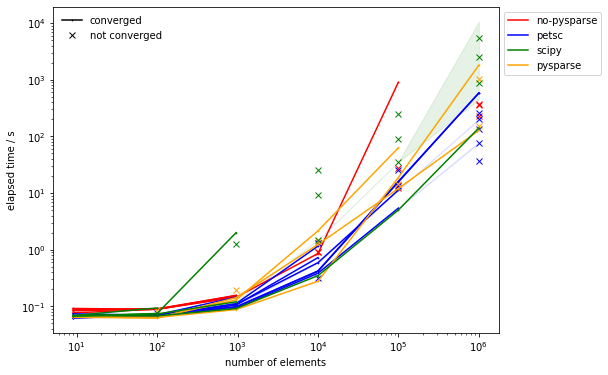

In [373]:
plot_all(macos_total)

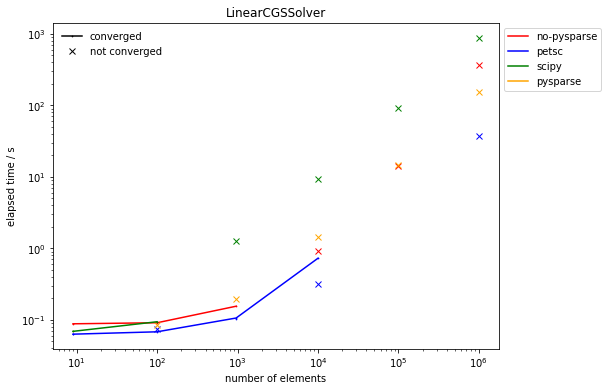

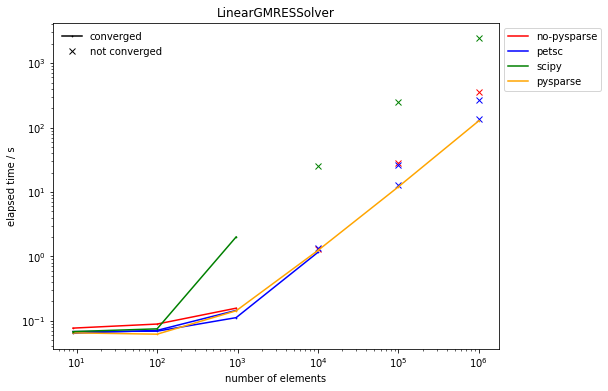

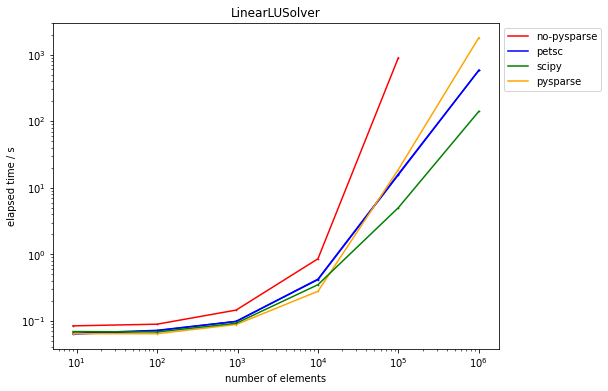

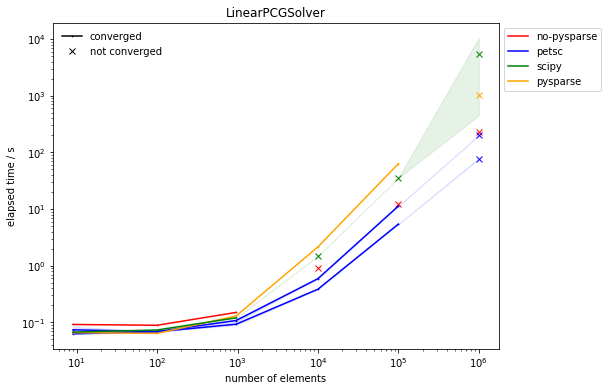

In [374]:
plot_by_solver(macos_total)

In [375]:
macos_sweep = extract_sweep_times(macos)

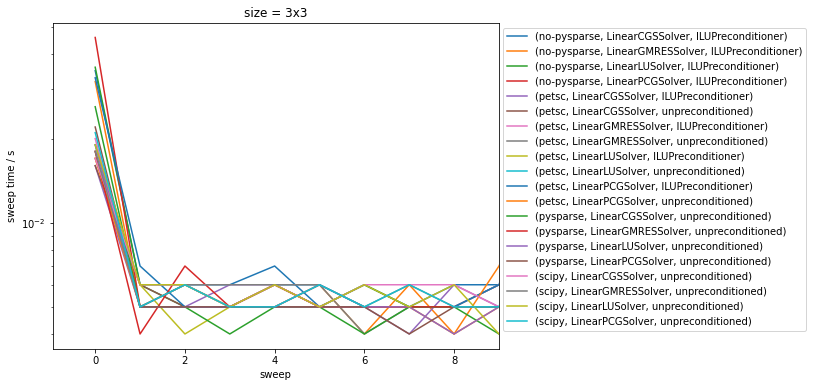

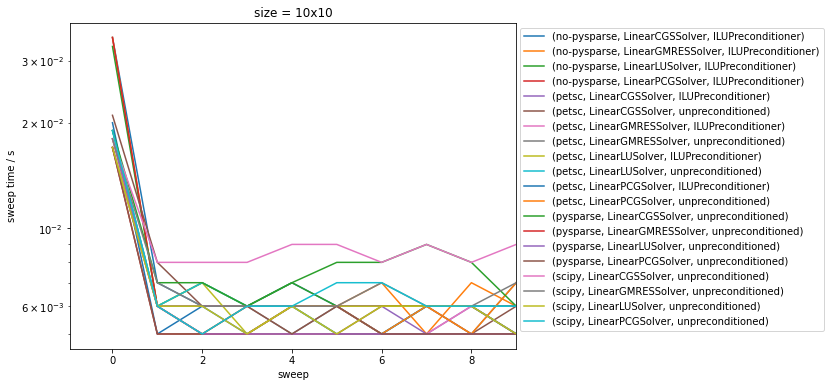

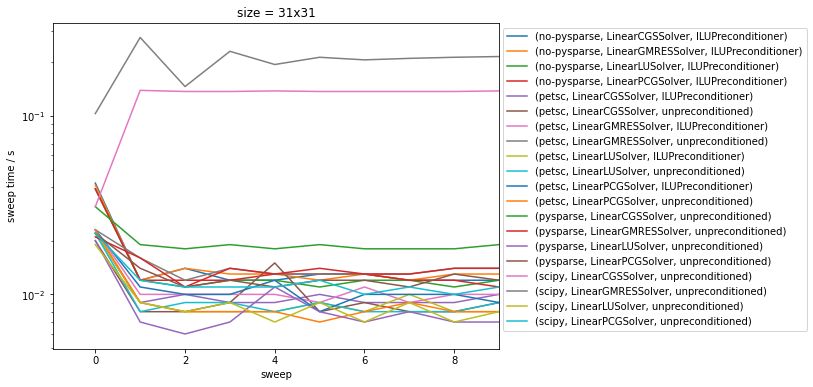

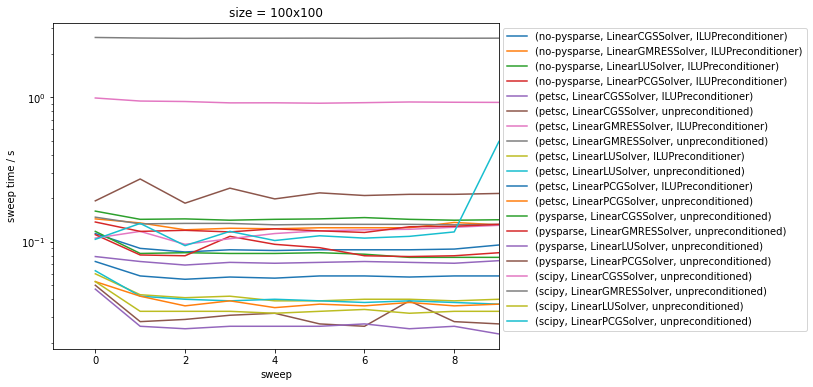

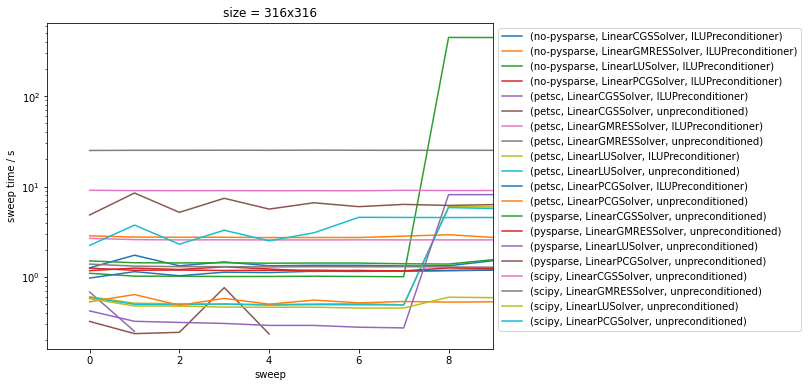

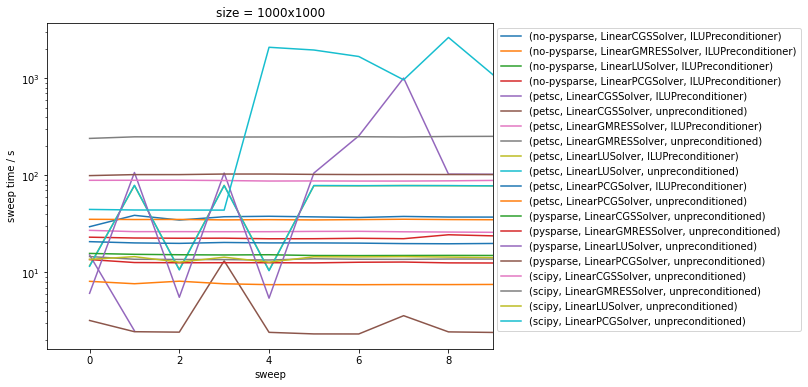

In [376]:
plot_sweep_times(macos_sweep)

### GPUs

In [377]:
gpu = events2df(read_events("gpu/gpu.log"))
gpu_total = extract_total_times(gpu)

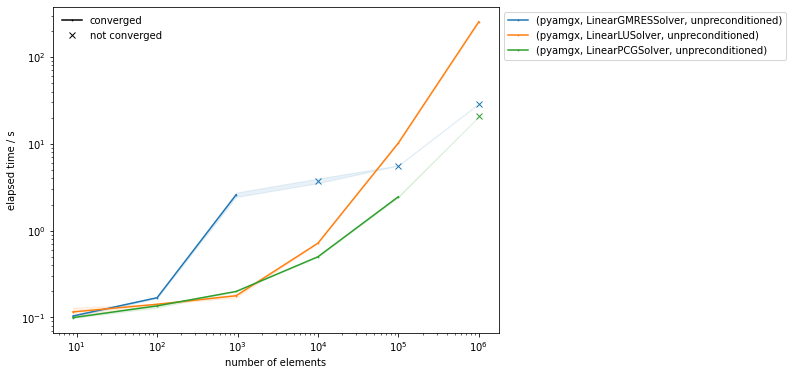

In [379]:
plot_all(gpu_total, color_by_suite=False)

In [380]:
gpu_sweep = extract_sweep_times(gpu)

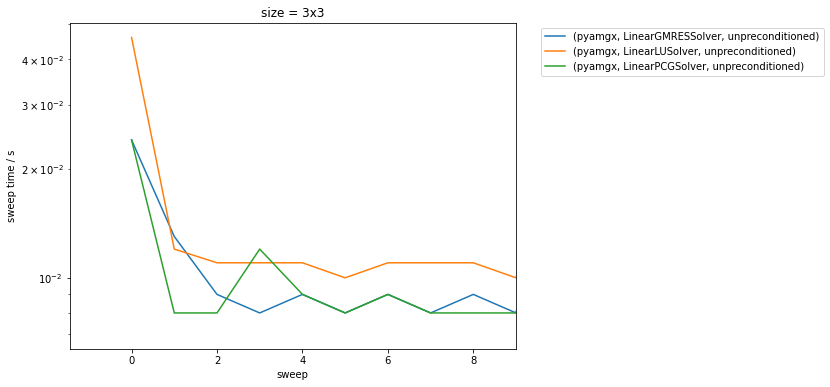

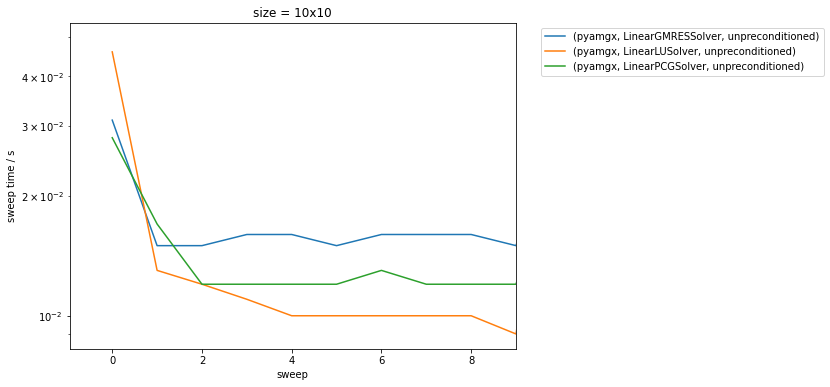

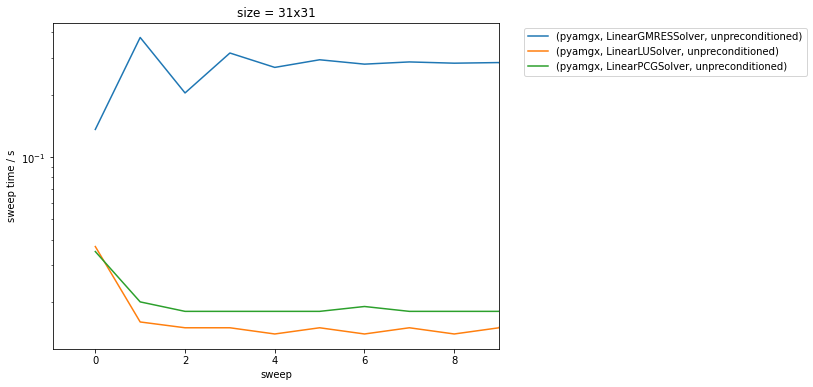

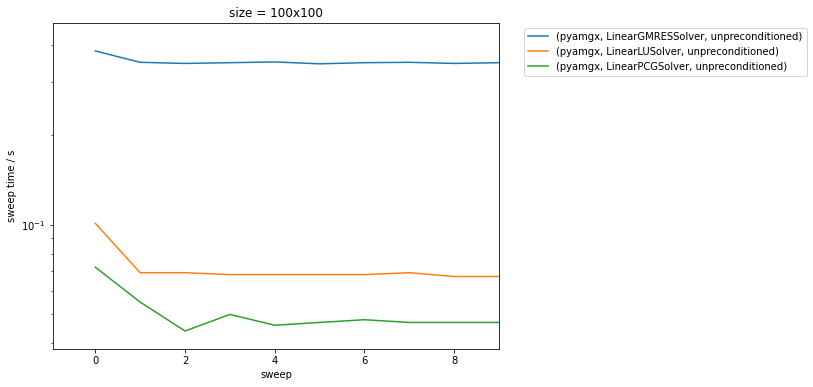

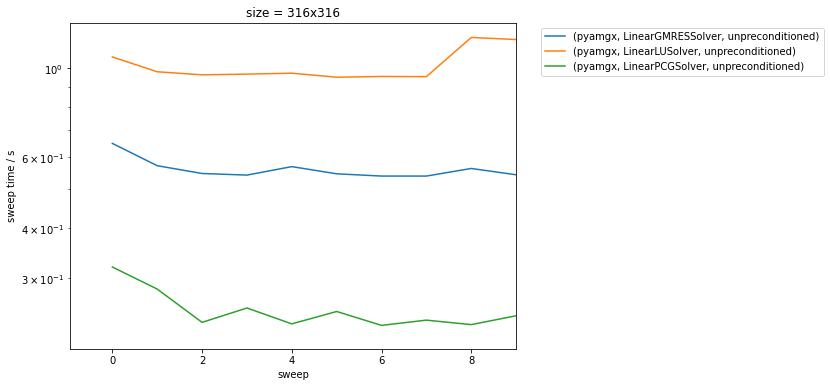

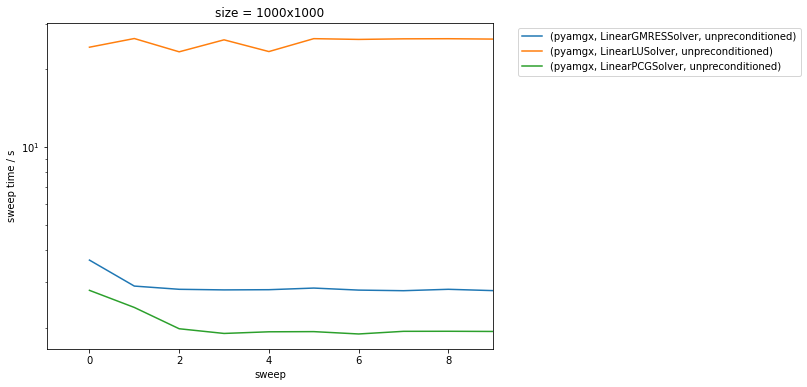

In [381]:
plot_sweep_times(gpu_sweep)

### Linux

In [764]:
events = []
for fname in glob.glob("linux/linux.*.log"):
    events.extend(read_events(fname))

linux = events2df(events)
linux_total = extract_total_times(linux)

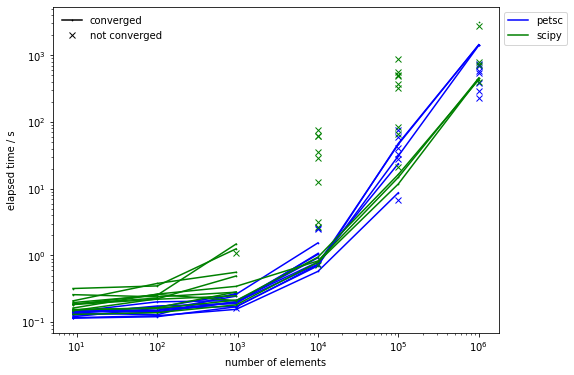

In [765]:
plot_all(linux_total)

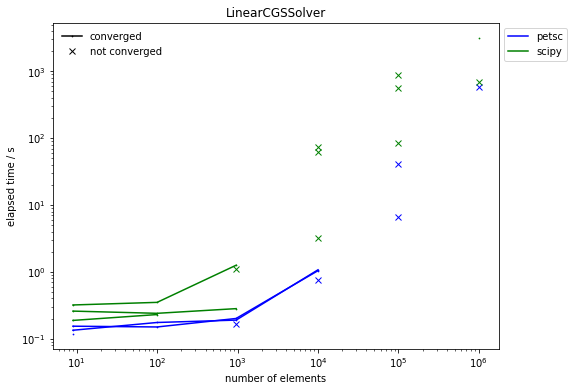

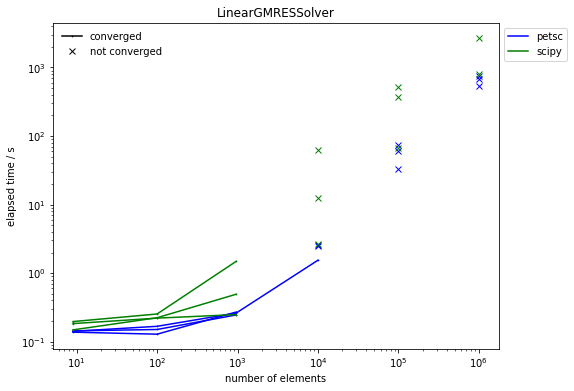

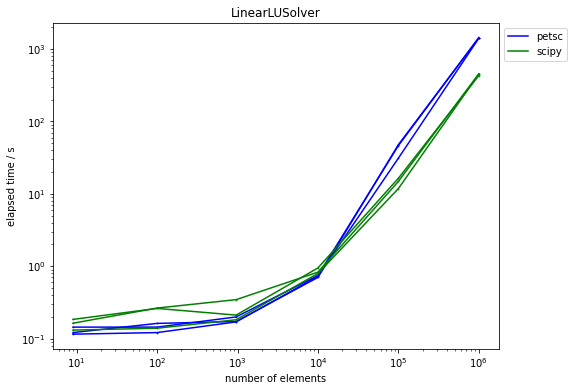

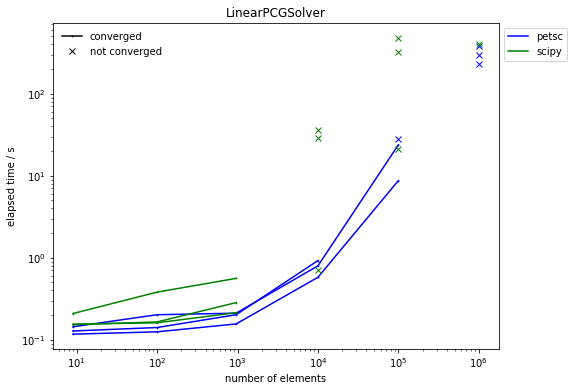

In [384]:
plot_by_solver(linux_total)

/var/folders/yc/1ssnjn654bs1n_0rts218cn0000j9v/T/ipykernel_35854/2043696119.py:27: RuntimeWarning: divide by zero encountered in log10
  ax.imshow(np.log10(np.absolute(diff)), cmap=cmap, vmin=-3, vmax=0)


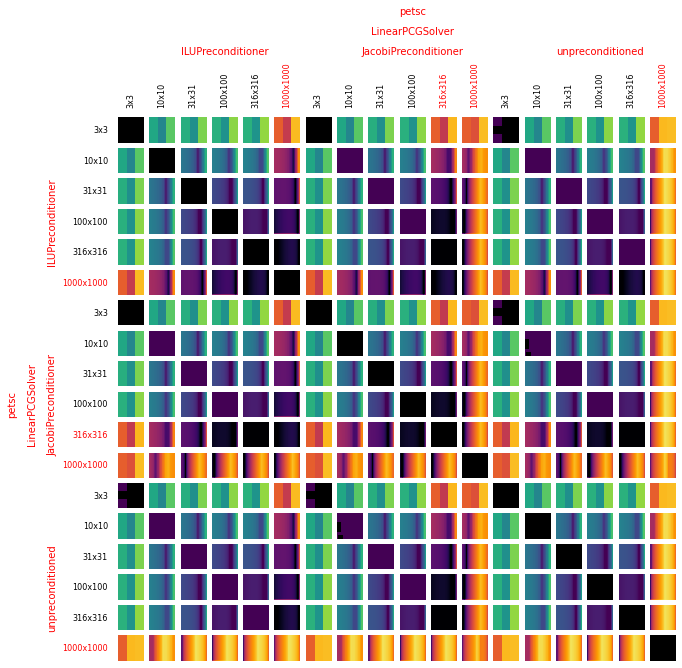

In [798]:
plot_error_matrix(linux_total[(linux_total["package.solver"] == "petsc")
                              & (linux_total["solver_class"].isin(["LinearPCGSolver"]))],
                  linux_total[(linux_total["package.solver"] == "petsc")
                              & (linux_total["solver_class"].isin(["LinearPCGSolver"]))],
                  by=["package.solver", "solver_class", "preconditioner", "numberOfElements"],
                  fname="solution.npz", key="value",
                  diff_fn=scale_and_diff)

/var/folders/yc/1ssnjn654bs1n_0rts218cn0000j9v/T/ipykernel_35854/2043696119.py:27: RuntimeWarning: divide by zero encountered in log10
  ax.imshow(np.log10(np.absolute(diff)), cmap=cmap, vmin=-3, vmax=0)


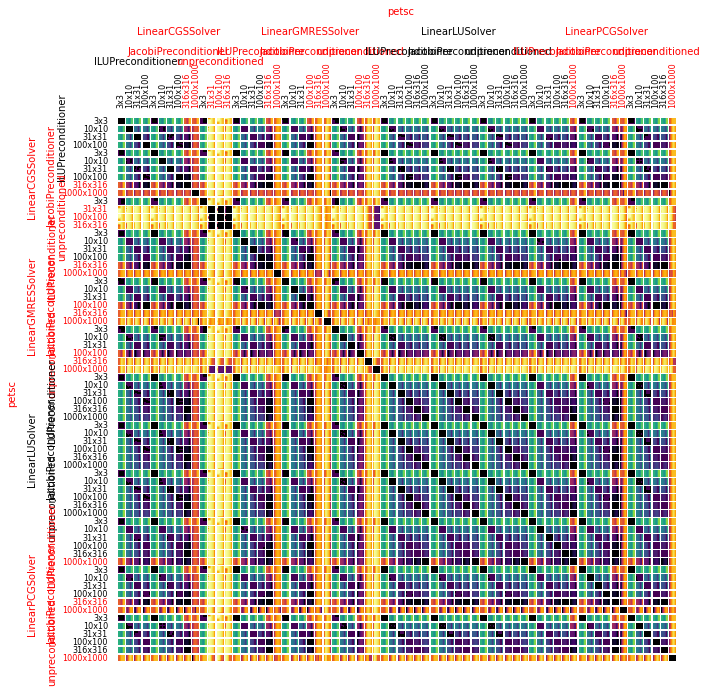

In [788]:
plot_error_matrix(linux_total[(linux_total["package.solver"] == "petsc")],
                  linux_total[(linux_total["package.solver"] == "petsc")],
                  by=["package.solver", "solver_class", "preconditioner", "numberOfElements"],
                  fname="solution.npz", key="value",
                  diff_fn=scale_and_diff)                  

/var/folders/yc/1ssnjn654bs1n_0rts218cn0000j9v/T/ipykernel_35854/4026615942.py:27: RuntimeWarning: divide by zero encountered in log10
  ax.imshow(np.log10(np.absolute(diff)), cmap=cmap, vmin=-3, vmax=0)


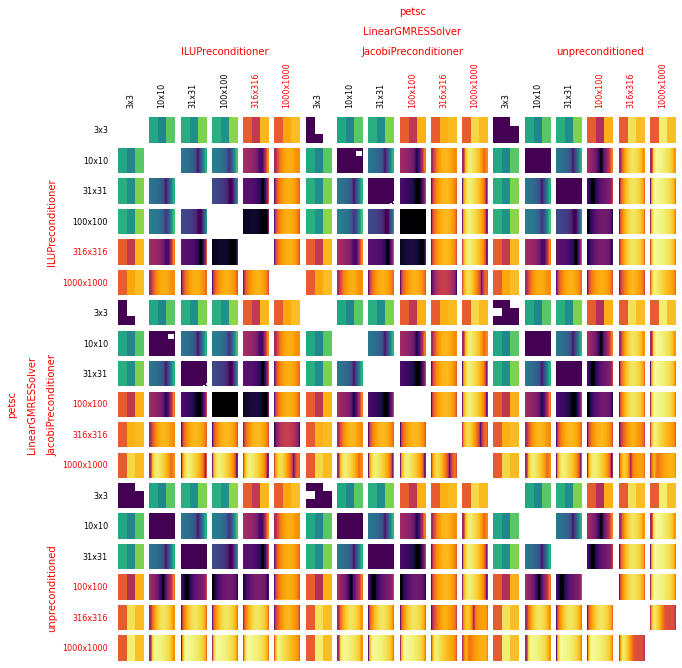

In [816]:
plot_error_matrix(linux_total[(linux_total["package.solver"] == "petsc")
                              & (linux_total["solver_class"] == "LinearGMRESSolver")],
                  linux_total[(linux_total["package.solver"] == "petsc")
                              & (linux_total["solver_class"] == "LinearGMRESSolver")],
                  by=["package.solver", "solver_class", "preconditioner", "numberOfElements"],
                  fname="solution.npz", key="value",
                  diff_fn=scale_and_diff)                  

#### arithmetic

In [397]:
events = []
for fname in glob.glob("../../../../solvers_and_timings/arithmetic_diffusion/solver.*.log"):
    events.extend(read_events(fname))

arithmetic = events2df(events)
arithmetic_total = extract_total_times(arithmetic)

(10.0, 1000000.0)

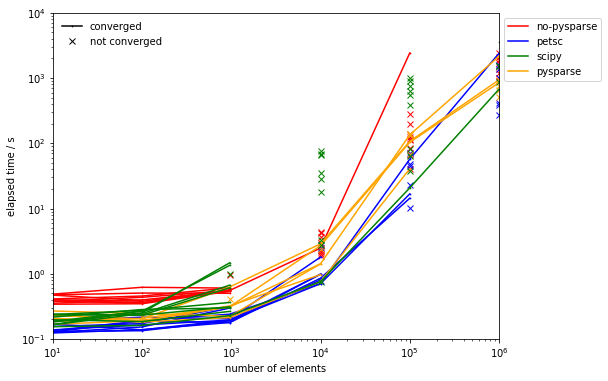

In [398]:
trilinos = arithmetic_total["package.solver"] == "no-pysparse"
petsc = arithmetic_total["package.solver"] == "petsc"
scipy = arithmetic_total["package.solver"] == "scipy"
pysparse = arithmetic_total["package.solver"] == "pysparse"

# plot_all(harmonic_total[pysparse | scipy])
plot_all(arithmetic_total)
plt.ylim(bottom=1e-1, top=1e4)
plt.xlim(left=1e1, right=1e6)

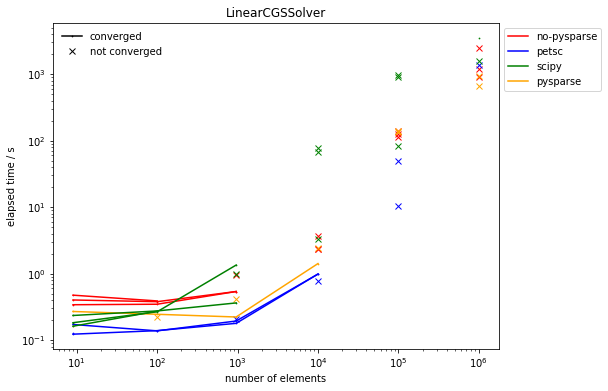

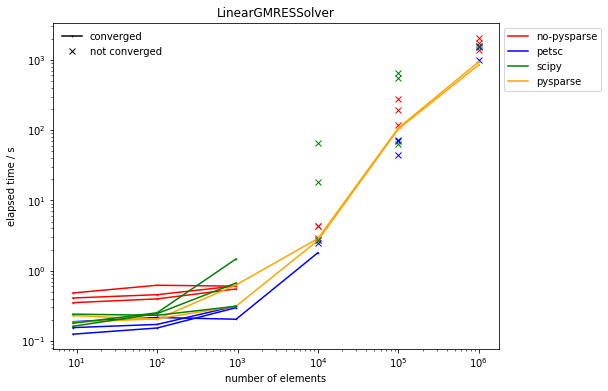

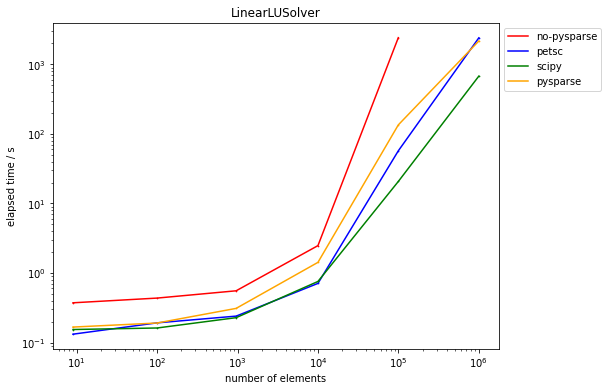

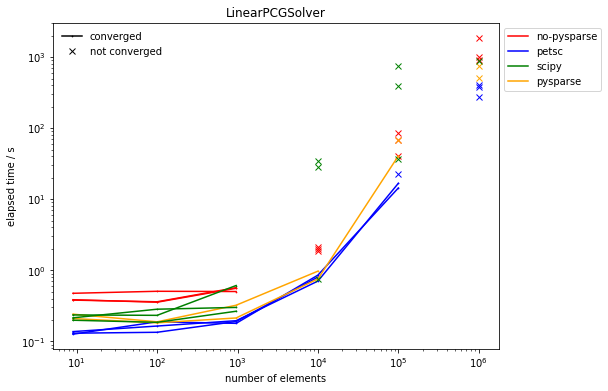

In [393]:
plot_by_solver(arithmetic_total)

#### harmonic-right

In [805]:
events = []
for fname in glob.glob("../../../../solvers_and_timings/harmonic_right/solver.*.log"):
    events.extend(read_events(fname))

harmonic_right = events2df(events)
harmonic_right_total = extract_total_times(harmonic_right)

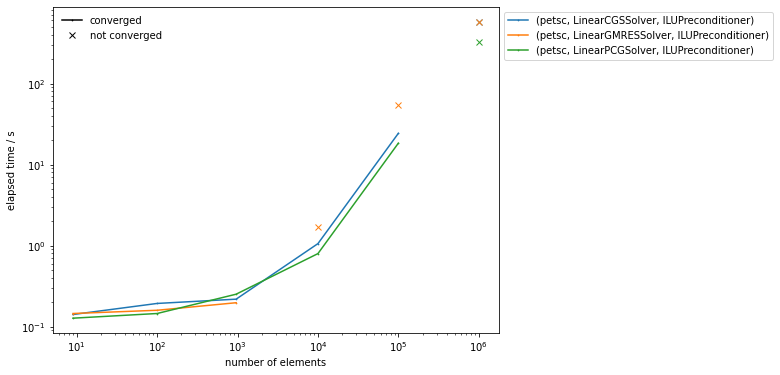

In [806]:
plot_all(harmonic_right_total, color_by_suite=False)

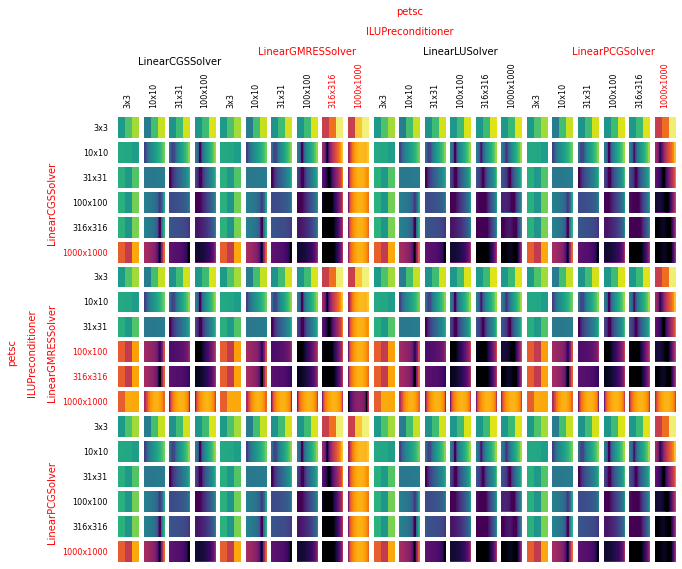

In [807]:
plot_error_matrix(linux_total[(linux_total["package.solver"] == "petsc")
                              & (linux_total["preconditioner"].isin(["ILUPreconditioner"]))],
                  harmonic_right_total[(harmonic_right_total["package.solver"] == "petsc")
                              & (harmonic_right_total["preconditioner"].isin(["ILUPreconditioner"]))],
                  by=["package.solver", "preconditioner", "solver_class", "numberOfElements"],
                  fname="solution.npz", key="value",
                  diff_fn=scale_and_diff)                  

#### harmonic

In [800]:
events = []
for fname in glob.glob("../../../../solvers_and_timings/harmonic/solver.*.log"):
    events.extend(read_events(fname))

harmonic = events2df(events)
harmonic_total = extract_total_times(harmonic)

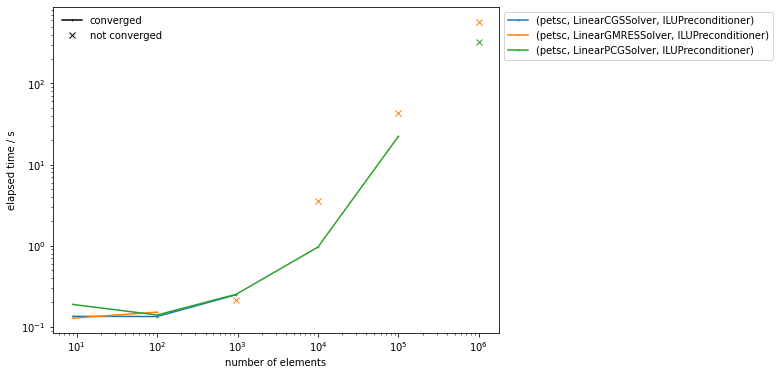

In [801]:
plot_all(harmonic_total, color_by_suite=False)

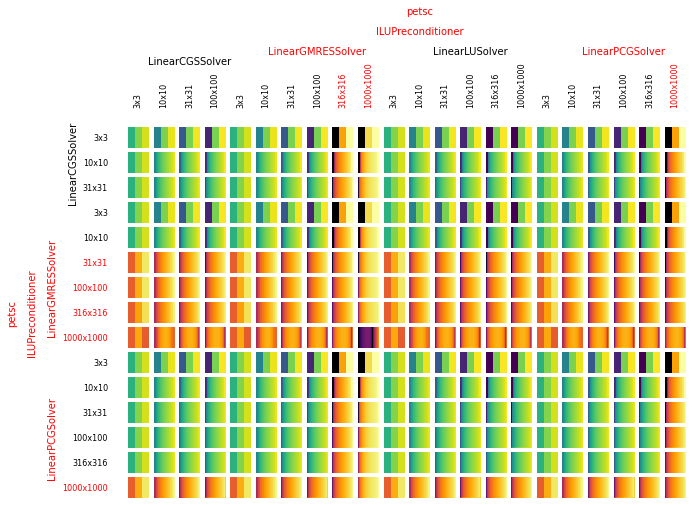

In [830]:
plot_error_matrix(linux_total[(linux_total["package.solver"] == "petsc")
                              & (linux_total["preconditioner"].isin(["ILUPreconditioner"]))],
                  harmonic_total[(harmonic_total["package.solver"] == "petsc")
                              & (harmonic_total["preconditioner"].isin(["ILUPreconditioner"]))],
                  by=["package.solver", "preconditioner", "solver_class", "numberOfElements"],
                  fname="solution.npz", key="value",
                  diff_fn=scale_and_diff)

#### constant

In [385]:
events = []
for fname in glob.glob("../../../../solvers_and_timings/constant_diffusion/solver.*.log"):
    events.extend(read_events(fname))

constant = events2df(events)
constant_total = extract_total_times(constant)

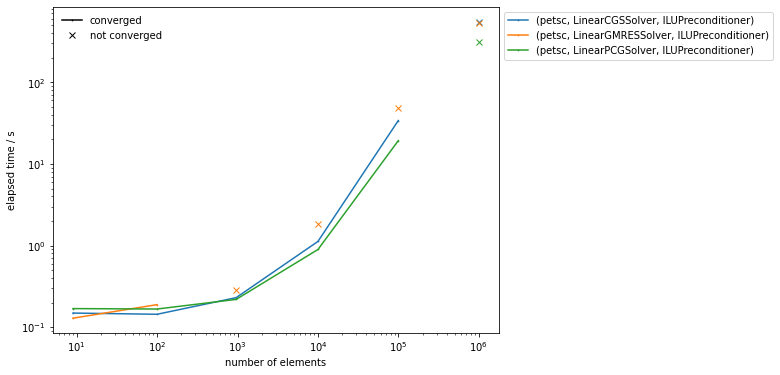

In [387]:
plot_all(constant_total, color_by_suite=False)

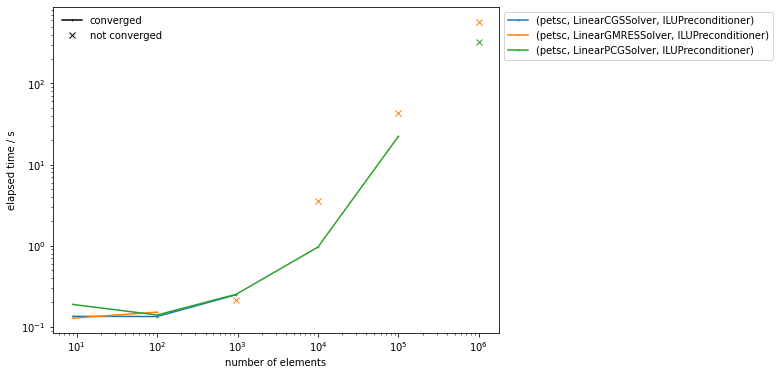

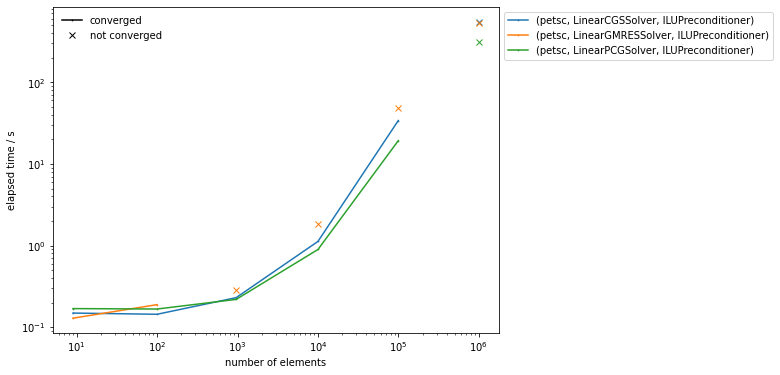

In [390]:
plot_all(harmonic_total, color_by_suite=False)
plot_all(constant_total, color_by_suite=False)

## nucleation

In [442]:
events = []
for fname in glob.glob("../../../../solvers_and_timings/nucleation2[3,5]/solver.*.log"):
    events.extend(read_events(fname))

nucleation = events2df(events)
nucleation_total = extract_total_times(nucleation)

In [408]:
for col in nucleation_total.columns:
    print(col)

state
numberOfElements
sweeps
preconditioner
logfile
time_stamp
solver_class
solve_time
simulation_id
converged
argv
platform.architecture
platform.machine
platform.node
platform.platform
platform.processor
platform.release
platform.system
platform.version
package.python
package.fipy
package.numpy
package.pysparse
package.scipy
package.matplotlib
package.mpi4py
package.petsc4py
package.pyamgx
package.PyTrilinos
package.mayavi
package.gmsh
package.solver
conda.conda_info.GID
conda.conda_info.UID
conda.conda_info.active_prefix
conda.conda_info.active_prefix_name
conda.conda_info.av_data_dir
conda.conda_info.av_metadata_url_base
conda.conda_info.channels
conda.conda_info.conda_build_version
conda.conda_info.conda_env_version
conda.conda_info.conda_location
conda.conda_info.conda_prefix
conda.conda_info.conda_private
conda.conda_info.conda_shlvl
conda.conda_info.conda_version
conda.conda_info.config_files
conda.conda_info.default_prefix
conda.conda_info.env_vars.CDPATH
conda.conda_info.env

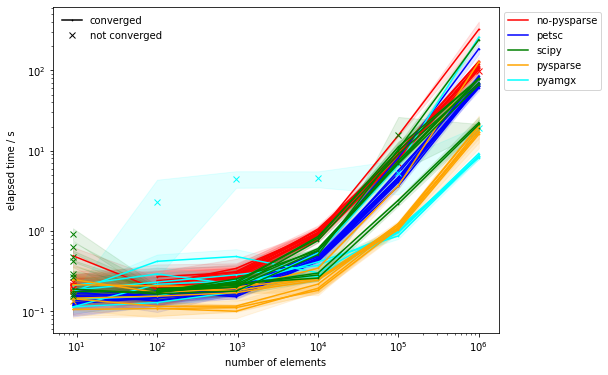

In [445]:
plot_all(nucleation_total)

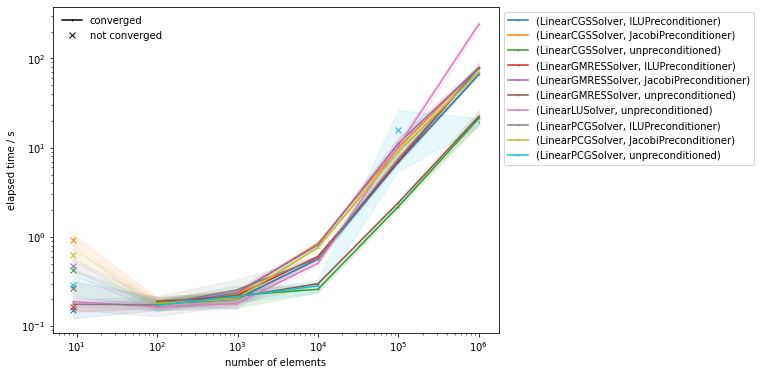

In [455]:
trilinos = nucleation_total["package.solver"] == "no-pysparse"
petsc = nucleation_total["package.solver"] == "petsc"
scipy = nucleation_total["package.solver"] == "scipy"
pysparse = nucleation_total["package.solver"] == "pysparse"
pyamgx = nucleation_total["package.solver"] == "pyamgx"

plot_all(nucleation_total[scipy], color_by_suite=False,
         by=["solver_class", "preconditioner"])
# plot_all(nucleation_total)
# plt.ylim(bottom=1e-1, top=1e3)
# plt.xlim(left=1e1, right=1e6)

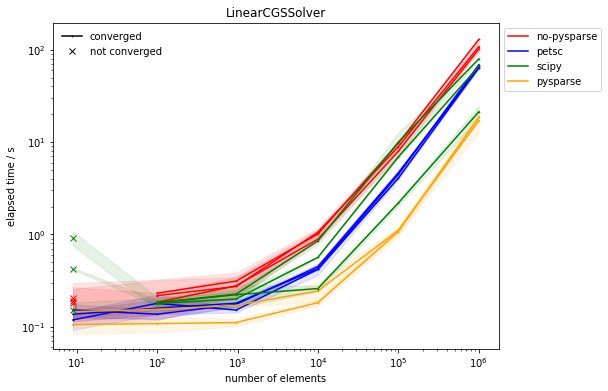

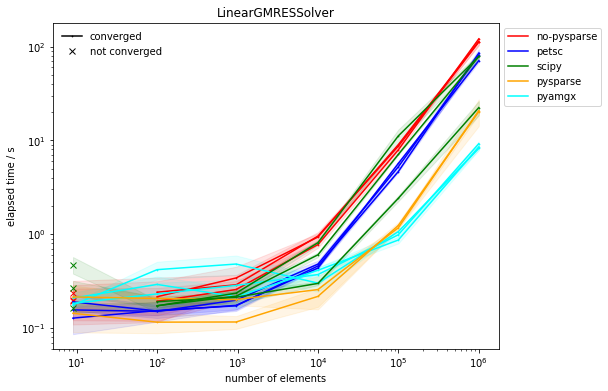

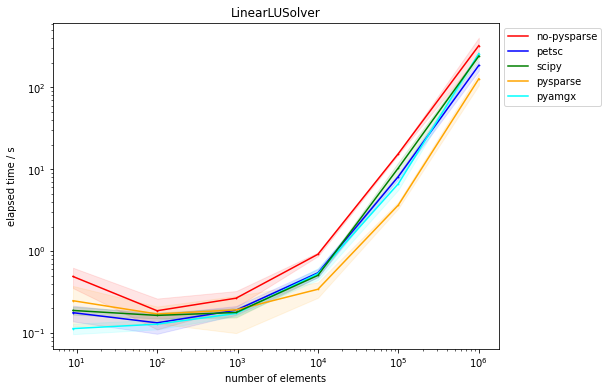

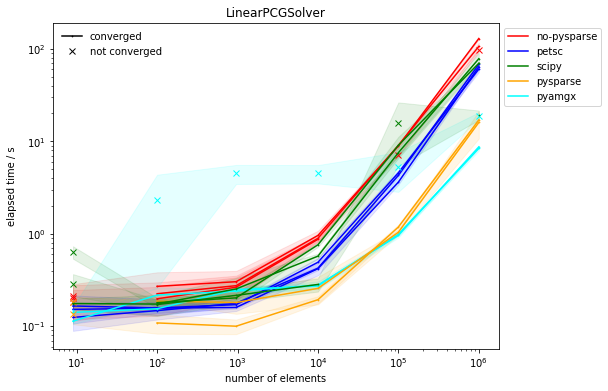

In [447]:
plot_by_solver(nucleation_total)

/var/folders/yc/1ssnjn654bs1n_0rts218cn0000j9v/T/ipykernel_35854/133901982.py:19: RuntimeWarning: divide by zero encountered in log10
  ax.imshow(np.log10(np.absolute(diff)), cmap=cmap, vmin=-3, vmax=0)


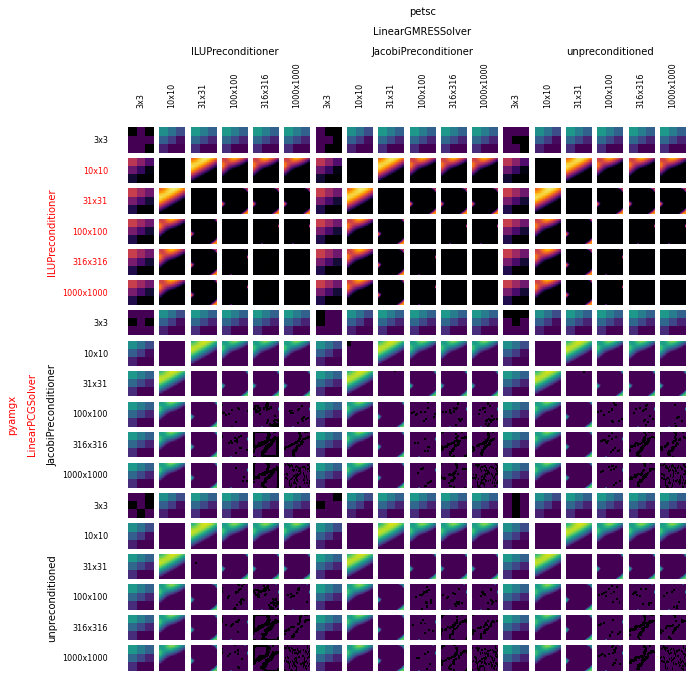

In [834]:
plot_error_matrix(nucleation_total[(nucleation_total["package.solver"] == "petsc")
                                   & (nucleation_total["solver_class"] == "LinearGMRESSolver")],
                  nucleation_total[(nucleation_total["package.solver"] == "pyamgx")
                                   & (nucleation_total["solver_class"] == "LinearPCGSolver")],
                  by=["package.solver", "solver_class", "preconditioner", "numberOfElements"],
                  fname="t=301.0.npz", key="phi",
                  diff_fn=extract_and_diff)

/var/folders/yc/1ssnjn654bs1n_0rts218cn0000j9v/T/ipykernel_35854/1420086669.py:64: RuntimeWarning: divide by zero encountered in log10
  ax.imshow(np.log10(np.absolute(diff)), cmap=cmap, vmin=-3, vmax=0)


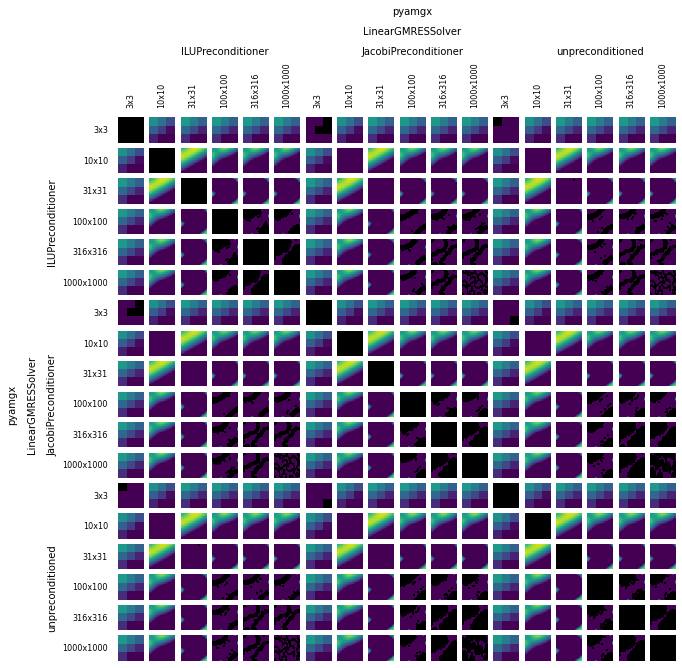

In [756]:
plot_error_matrix(nucleation_total[(nucleation_total["package.solver"] == "pyamgx")
                                   & (nucleation_total["solver_class"] == "LinearGMRESSolver")],
                  nucleation_total[(nucleation_total["package.solver"] == "pyamgx")
                                   & (nucleation_total["solver_class"] == "LinearGMRESSolver")],
                  by=["package.solver", "solver_class", "preconditioner", "numberOfElements"],
                  fname="t=301.0.npz", key="phi",
                  diff_fn=extract_and_diff)

/var/folders/yc/1ssnjn654bs1n_0rts218cn0000j9v/T/ipykernel_35854/1420086669.py:64: RuntimeWarning: divide by zero encountered in log10
  ax.imshow(np.log10(np.absolute(diff)), cmap=cmap, vmin=-3, vmax=0)


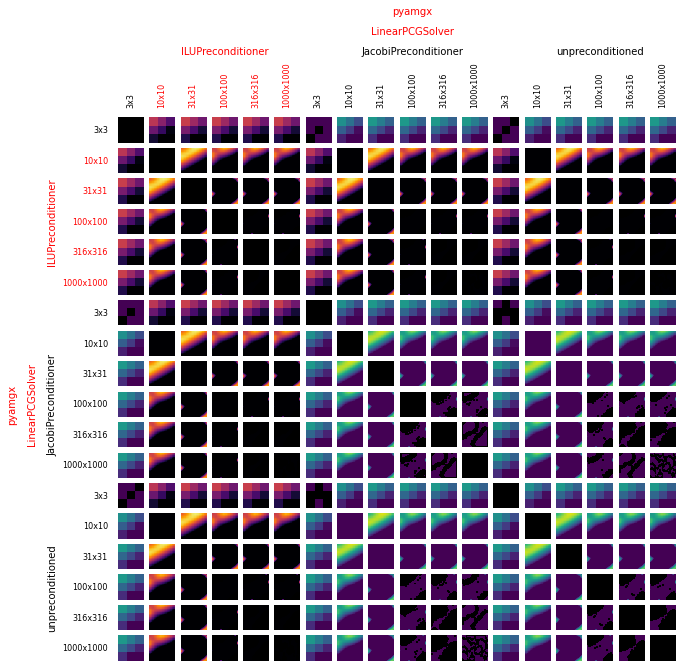

In [757]:
plot_error_matrix(nucleation_total[(nucleation_total["package.solver"] == "pyamgx")
                                   & (nucleation_total["solver_class"] == "LinearPCGSolver")],
                  nucleation_total[(nucleation_total["package.solver"] == "pyamgx")
                                   & (nucleation_total["solver_class"] == "LinearPCGSolver")],
                  by=["package.solver", "solver_class", "preconditioner", "numberOfElements"],
                  fname="t=301.0.npz", key="phi",
                  diff_fn=extract_and_diff)

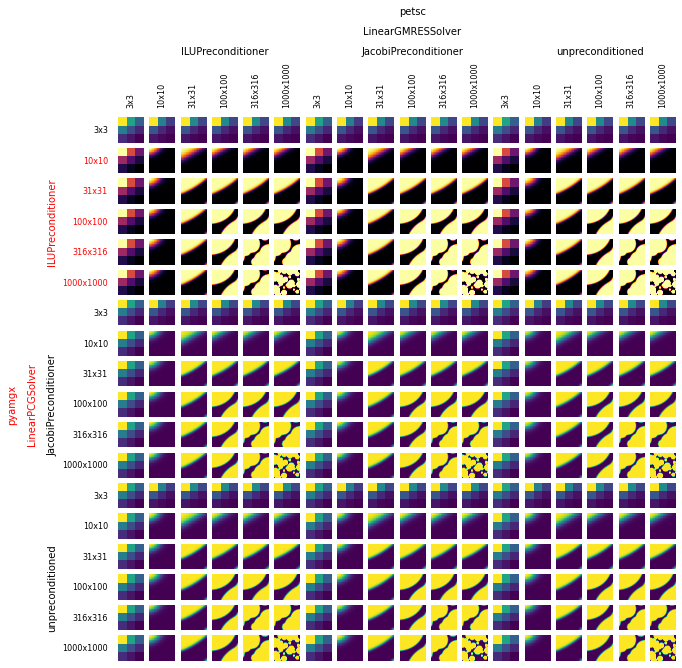

In [813]:
plot_error_matrix(nucleation_total[(nucleation_total["package.solver"] == "petsc")
                                   & (nucleation_total["solver_class"] == "LinearGMRESSolver")],
                  nucleation_total[(nucleation_total["package.solver"] == "pyamgx")
                                   & (nucleation_total["solver_class"] == "LinearPCGSolver")],
                  by=["package.solver", "solver_class", "preconditioner", "numberOfElements"],
                  fname="t=301.0.npz", key="phi",
                  diff_fn=value1, logscale=False)

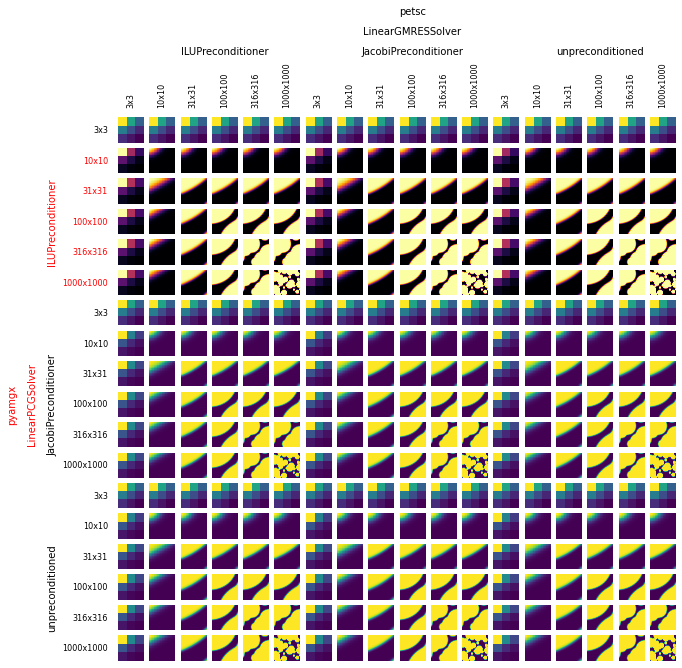

In [814]:
plot_error_matrix(nucleation_total[(nucleation_total["package.solver"] == "petsc")
                                   & (nucleation_total["solver_class"] == "LinearGMRESSolver")],
                  nucleation_total[(nucleation_total["package.solver"] == "pyamgx")
                                   & (nucleation_total["solver_class"] == "LinearPCGSolver")],
                  by=["package.solver", "solver_class", "preconditioner", "numberOfElements"],
                  fname="t=301.0.npz", key="phi",
                  diff_fn=value2, logscale=False)

/var/folders/yc/1ssnjn654bs1n_0rts218cn0000j9v/T/ipykernel_35854/1420086669.py:64: RuntimeWarning: divide by zero encountered in log10
  ax.imshow(np.log10(np.absolute(diff)), cmap=cmap, vmin=-3, vmax=0)


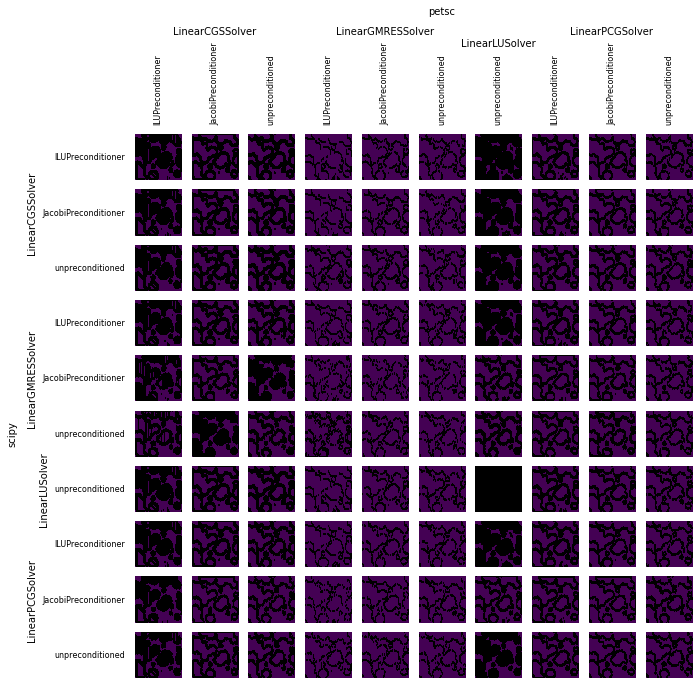

In [752]:
plot_error_matrix(nucleation_total[(nucleation_total["package.solver"] == "petsc")
                                   & (nucleation_total["numberOfElements"] == 10**6)],
                  nucleation_total[(nucleation_total["package.solver"] == "scipy")
                                   & (nucleation_total["numberOfElements"] == 10**6)],
                  by=["package.solver", "solver_class", "preconditioner"],
                  fname="t=301.0.npz", key="phi",
                  diff_fn=extract_and_diff)

/var/folders/yc/1ssnjn654bs1n_0rts218cn0000j9v/T/ipykernel_35854/3586271709.py:39: RuntimeWarning: divide by zero encountered in log10
  ax.imshow(np.log10(np.absolute(diff)), cmap=cmap, vmin=-3, vmax=0)


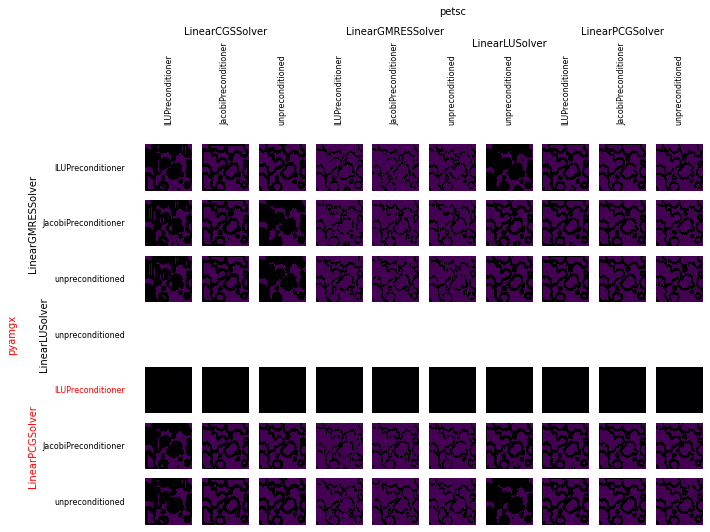

In [839]:
plot_error_matrix(nucleation_total[(nucleation_total["package.solver"] == "petsc")
                                   & (nucleation_total["numberOfElements"] == 10**6)],
                  nucleation_total[(nucleation_total["package.solver"] == "pyamgx")
                                   & (nucleation_total["numberOfElements"] == 10**6)],
                  by=["package.solver", "solver_class", "preconditioner"],
                  fname="t=301.0.npz", key="phi",
                  diff_fn=extract_and_diff)

## convert solutions

In [125]:
for path in glob.glob("linux/petsc/LinearPCGSolver/*/*/solution.tsv"):
    tsv2npz(path)

In [354]:
for path in glob.glob("linux/petsc/LinearGMRESSolver/*/*/solution.tsv"):
    tsv2npz(path)

In [355]:
for path in glob.glob("linux/petsc/LinearCGSSolver/*/*/solution.tsv"):
    tsv2npz(path)

In [356]:
for path in glob.glob("linux/petsc/LinearLUSolver/*/*/solution.tsv"):
    tsv2npz(path)

In [357]:
for path in glob.glob("linux/scipy/*/*/*/solution.tsv"):
    tsv2npz(path)

## scratch

In [790]:
int((1000 - 3) / 2), int((1000 + 3) / 2)

(498, 501)

In [793]:
(1000 - 316) // 2, (1000 + 316) // 2

(342, 658)

In [795]:
(316 - 3) // 2 + 342, (316 + 3) // 2 + 342

(498, 501)

In [796]:
int((1000 - 10) / 2), int((1000 + 10) / 2)

(495, 505)

In [797]:
(316 - 10) // 2 + 342, (316 + 10) // 2 + 342

(495, 505)